In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for number crunching
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

# Extre libraries
from datetime import datetime

/kaggle/input/online-retail-ii-uci/online_retail_II.csv


In [2]:
os.listdir('/kaggle/input/online-retail-ii-uci')

['online_retail_II.csv']

In [3]:
data = pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv')

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


# Creating necessary columns

In [5]:
# Making sure Date is in datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Total ammount column
data['TotalAmount'] = data['Price'] * data['Quantity']

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


# Dropping null columns

In [6]:
# Validating null values
data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
TotalAmount         0
dtype: int64

In [7]:
# Validating negative values
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price              5
Quantity       22950
TotalAmount    19498
dtype: int64

In [8]:
# Deleting all rows with null values
data = data.dropna(subset = ['Customer ID'])

# Eliminating rows with negative quantities

# Note: don't eliminate this data, TO BE DETERMINED

data = data[data['Quantity'] >= 0]

data = data[data['Price'] >= 0]

In [9]:
# Making lists with Customers with heavily outlying behavior
# OutlierCustomersPrice = data[data['Price'] > data['Price'].quantile(0.99)]['Customer ID'].unique()
# OutlierCustomersQuantity = data[data['Quantity'] > data['Quantity'].quantile(0.99)]['Customer ID'].unique()
# OutlierCustomersTotalAmount = data[data['TotalAmount'] > data['TotalAmount'].quantile(0.99)]['Customer ID'].unique()

In [10]:
# # Combinning the lists
# outlierCustomers = np.union1d(np.union1d(OutlierCustomersPrice, OutlierCustomersQuantity),OutlierCustomersTotalAmount)

# # Excluding outliers from data
# data = data[~data['Customer ID'].isin(outlierCustomers)]

In [11]:
# Making lists with Customers with heavily outlying behavior
OutlierCustomersPrice = data[data['Price'] > data['Price'].quantile(0.9995)]['Customer ID'].unique()
OutlierCustomersQuantity = data[data['Quantity'] > data['Quantity'].quantile(0.9995)]['Customer ID'].unique()

# Combinning the lists
outlierCustomers = np.union1d(OutlierCustomersPrice, OutlierCustomersQuantity)

# Excluding outliers from data
data = data[~data['Customer ID'].isin(outlierCustomers)]

In [12]:
# Validating null values again
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalAmount    0
dtype: int64

In [13]:
# Validating negative values again
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price          0
Quantity       0
TotalAmount    0
dtype: int64

# Data Cleaning

<function matplotlib.pyplot.show(close=None, block=None)>

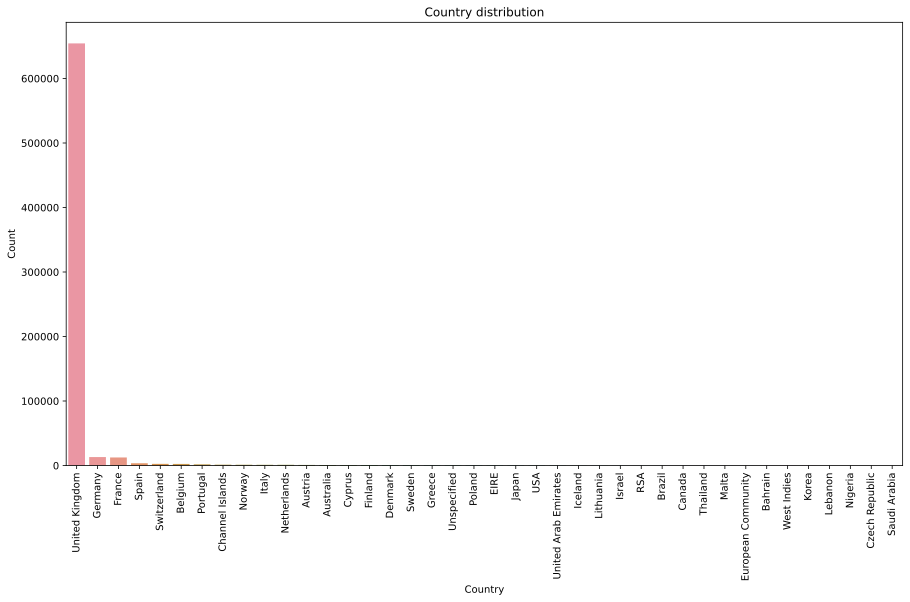

In [14]:
# Country distribution
plt.figure(figsize=(15, 8))
sns.countplot(data= data, x='Country', order=data['Country'].value_counts().index)
plt.title('Country distribution')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation= 90)
plt.show

In [15]:
# We'll only work with transactions from the UK

# Keeping only transactions made in the UK
data = data[data['Country'] == 'United Kingdom']

In [16]:
print(data['Country'].describe())

count             654357
unique                 1
top       United Kingdom
freq              654357
Name: Country, dtype: object


# Price, Quantity and Total Amount distributions

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Quantity', ylabel='Percent'>

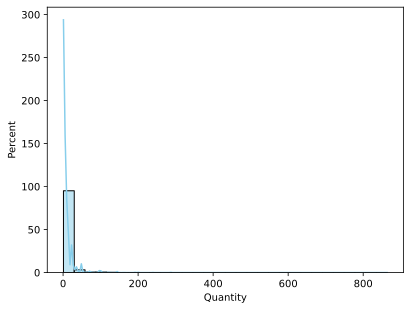

In [17]:
sns.histplot(data['Quantity'],bins=30, kde=True, color="skyblue", stat="percent")

In [18]:
# Distribution for Quantity
print(data['Quantity'].describe())

count    654357.000000
mean          9.653918
std          21.062353
min           1.000000
25%           2.000000
50%           4.000000
75%          12.000000
max         864.000000
Name: Quantity, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Price', ylabel='Percent'>

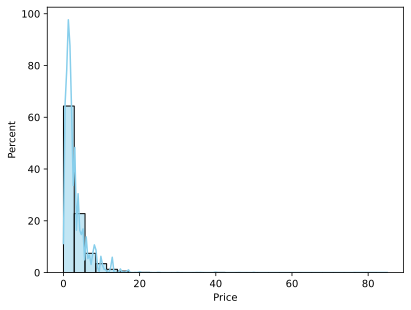

In [19]:
sns.histplot(data['Price'],bins=30, kde=True, color="skyblue", stat="percent")

In [20]:
# Distribution for Price
print(data['Price'].describe())

count    654357.000000
mean          2.874230
std           3.089849
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max          85.000000
Name: Price, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='TotalAmount', ylabel='Percent'>

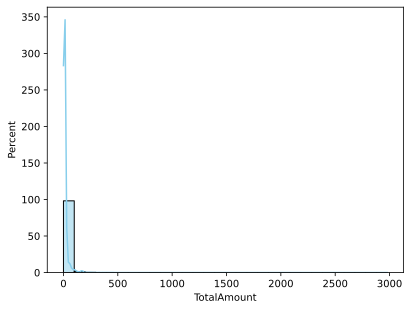

In [21]:
sns.histplot(data['TotalAmount'],bins=30, kde=True, color="skyblue", stat="percent")

In [22]:
# Distribution for TotalAmount
print(data['TotalAmount'].describe())

count    654357.000000
mean         16.637805
std          32.451979
min           0.000000
25%           4.160000
50%          10.200000
75%          17.700000
max        2978.400000
Name: TotalAmount, dtype: float64


# Data division between present and future

In [23]:
futureMax = data['InvoiceDate'].max()

print(futureMax)

2011-12-09 12:49:00


In [24]:
# Data delimitation (three months before)
presentvalue = pd.Timestamp('2011-09-01')

print(presentvalue)

2011-09-01 00:00:00


In [25]:
# Dividing data between present and future
futureData = data[(data['InvoiceDate'] > presentvalue) & (data['InvoiceDate'] <= presentvalue + pd.DateOffset(months=3))]

data = data[data['InvoiceDate'] <= presentvalue]

In [26]:
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517704 entries, 0 to 846153
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      517704 non-null  object        
 1   StockCode    517704 non-null  object        
 2   Description  517704 non-null  object        
 3   Quantity     517704 non-null  int64         
 4   InvoiceDate  517704 non-null  datetime64[ns]
 5   Price        517704 non-null  float64       
 6   Customer ID  517704 non-null  float64       
 7   Country      517704 non-null  object        
 8   TotalAmount  517704 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 39.5+ MB


In [28]:
futureData.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
846166,565080,20677,PINK POLKADOT BOWL,8,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,10.0
846167,565080,22128,PARTY CONES CANDY ASSORTED,24,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,30.0
846169,565082,22423,REGENCY CAKESTAND 3 TIER,2,2011-09-01 09:15:00,12.75,13305.0,United Kingdom,25.5
846170,565082,15060B,FAIRY CAKE DESIGN UMBRELLA,8,2011-09-01 09:15:00,3.75,13305.0,United Kingdom,30.0
846171,565082,23245,SET OF 3 REGENCY CAKE TINS,4,2011-09-01 09:15:00,4.95,13305.0,United Kingdom,19.8


In [29]:
futureData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122624 entries, 846166 to 1041829
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      122624 non-null  object        
 1   StockCode    122624 non-null  object        
 2   Description  122624 non-null  object        
 3   Quantity     122624 non-null  int64         
 4   InvoiceDate  122624 non-null  datetime64[ns]
 5   Price        122624 non-null  float64       
 6   Customer ID  122624 non-null  float64       
 7   Country      122624 non-null  object        
 8   TotalAmount  122624 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 9.4+ MB


# Creating Customer Dataset

In [30]:
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [31]:
# Calculating the "present day" for metrics like Recency
presentDay = presentvalue

# Calculate date metrics
firstPurchase = data.groupby('Customer ID')['InvoiceDate'].min()
lastPurchase = data.groupby('Customer ID')['InvoiceDate'].max()

# Calculate customer lifespan metrics
# We don't want 0 in active days. First day counts as 1.
activeDays = (lastPurchase - firstPurchase).dt.days + 1

# Recency calculation (Days since last purchase)
recency = (presentDay - lastPurchase).dt.days

activeYears = activeDays / 365.25
activeMonths = activeDays / 30.44

# A stabilization for active months so FrequencyPerMonth doesn't give
# new customer extreme values
activeMonthsSafe = np.maximum(activeMonths, 1)

# Last 30 days
last_30d = data[data['InvoiceDate'] > presentDay - pd.DateOffset(days=30)]
last_30d_spending = last_30d.groupby('Customer ID')['TotalAmount'].sum()
last_30d_frequency = last_30d.groupby('Customer ID')['Invoice'].nunique()

# Last 60 days
last_60d = data[data['InvoiceDate'] > presentDay - pd.DateOffset(days=60)]
last_60d_spending = last_60d.groupby('Customer ID')['TotalAmount'].sum()
last_60d_frequency = last_60d.groupby('Customer ID')['Invoice'].nunique()

# Last 90 days
last_90d = data[data['InvoiceDate'] > presentDay - pd.DateOffset(days=90)]
last_90d_spending = last_90d.groupby('Customer ID')['TotalAmount'].sum()
last_90d_frequency = last_90d.groupby('Customer ID')['Invoice'].nunique()

# Frequency calculation
purchaseFrequency = data.groupby('Customer ID')['Invoice'].nunique()

# Monetary for calculations
monetary = data.groupby('Customer ID')['TotalAmount'].sum()

# Quantity calculation (calculating the total quantity per invoice)
invoiceQuantity = data.groupby(['Customer ID','Invoice'])['Quantity'].sum().reset_index()
avgQuantityPerInvoice = invoiceQuantity.groupby('Customer ID')['Quantity'].mean()

customerData = data.groupby('Customer ID').agg(

    # Monetary (Total Amount of purchases)
    Monetary = ('TotalAmount', 'sum'),
    
    # Average item Price
    #AvgPrice = ('Price', 'mean'), 
    
    # How many unique products bought
    ProductDiversity = ('StockCode', 'nunique')
)

# Recency calculation (Days since last purchase)
customerData['Recency'] = recency

# Frequency calculation
customerData['Frequency'] = purchaseFrequency

# Average order value calculation
customerData['AvgInvoiceValue'] = monetary / purchaseFrequency

# Average Quantity table merge
customerData['AvgQuantityPerInvoice'] = avgQuantityPerInvoice

# Active days
customerData['ActiveDays'] = activeDays

# Average item price
AvgPrice = data.groupby('Customer ID').apply(lambda x: x['TotalAmount'].sum() / x['Quantity'].sum())

# Spending in different time windows
customerData['Spending_Last30d'] = last_30d_spending
customerData['Spending_Last60d'] = last_60d_spending
customerData['Spending_Last90d'] = last_90d_spending

# Frequency in different time windows
customerData['Frequency_Last30d'] = last_30d_frequency
customerData['Frequency_Last60d'] = last_60d_frequency
customerData['Frequency_Last90d'] = last_90d_frequency

# Fill NaN values with 0 for customers with no activity in recent windows
temporal_cols = ['Spending_Last30d', 'Spending_Last60d', 'Spending_Last90d',
                 'Frequency_Last30d', 'Frequency_Last60d', 'Frequency_Last90d']

customerData[temporal_cols] = customerData[temporal_cols].fillna(0)

# Frequency per month
customerData['FrequencyPerMonth'] = purchaseFrequency / activeMonthsSafe

# Calculation of future CLV (spending in the next Quarter), which will be the target
futureCLV = futureData.groupby('Customer ID')['TotalAmount'].sum().rename('FutureCLV')
finalDataset = customerData.merge(futureCLV, how = 'left', left_index = True, right_index = True)
# Filling customers with no spending with a 0 value
finalDataset['FutureCLV'] = finalDataset['FutureCLV'].fillna(0)

# Eliminating customers with only 1 purchase as they only worsen the MAE
finalDataset = finalDataset[finalDataset['Frequency'] >= 2]

finalDataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3162 entries, 12747.0 to 18287.0
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Monetary               3162 non-null   float64
 1   ProductDiversity       3162 non-null   int64  
 2   Recency                3162 non-null   int64  
 3   Frequency              3162 non-null   int64  
 4   AvgInvoiceValue        3162 non-null   float64
 5   AvgQuantityPerInvoice  3162 non-null   float64
 6   ActiveDays             3162 non-null   int64  
 7   Spending_Last30d       3162 non-null   float64
 8   Spending_Last60d       3162 non-null   float64
 9   Spending_Last90d       3162 non-null   float64
 10  Frequency_Last30d      3162 non-null   float64
 11  Frequency_Last60d      3162 non-null   float64
 12  Frequency_Last90d      3162 non-null   float64
 13  FrequencyPerMonth      3162 non-null   float64
 14  FutureCLV              3162 non-null   float64
dtype

/tmp/ipykernel_47/1337570770.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  AvgPrice = data.groupby('Customer ID').apply(lambda x: x['TotalAmount'].sum() / x['Quantity'].sum())


In [32]:
finalDataset.head(10)

,Monetary,ProductDiversity,Recency,Frequency,AvgInvoiceValue,AvgQuantityPerInvoice,ActiveDays,Spending_Last30d,Spending_Last60d,Spending_Last90d,Frequency_Last30d,Frequency_Last60d,Frequency_Last90d,FrequencyPerMonth,FutureCLV
Customer ID,,,,,,,,,,,,,,,
12747.0,7849.93,79,9,23,341.301304,101.956522,623,301.7,301.70,678.00,1.0,1.0,2.0,1.123788,988.11
12749.0,5561.71,219,30,7,794.530000,281.285714,391,0.0,1896.13,1896.13,0.0,2.0,2.0,0.544962,572.59
12820.0,1917.64,91,226,8,239.705000,173.750000,408,0.0,0.00,0.00,0.0,0.0,0.0,0.596863,561.53
12821.0,220.80,13,114,2,110.400000,81.000000,398,0.0,0.00,0.00,0.0,0.0,0.0,0.152965,0.00
12823.0,5966.00,1,27,17,350.941176,50.588235,553,229.5,229.50,229.50,1.0,1.0,1.0,0.935769,535.50
12825.0,518.63,20,421,2,259.315000,69.500000,121,0.0,0.00,0.00,0.0,0.0,0.0,0.503140,0.00
12826.0,2299.65,86,78,9,255.516667,184.222222,543,0.0,0.00,121.52,0.0,0.0,1.0,0.504530,513.50
12828.0,338.20,19,12,2,169.100000,66.000000,18,111.2,338.20,338.20,1.0,2.0,2.0,2.000000,323.11
12829.0,385.30,17,236,3,128.433333,183.333333,214,0.0,0.00,0.00,0.0,0.0,0.0,0.426729,0.00


In [33]:
# Saving a clean copy of the final dataset before cleaning it
rawCustomerDataset = finalDataset.copy()

# Client segmentation (Excluding clients with outlying purchase patters)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Monetary', ylabel='Percent'>

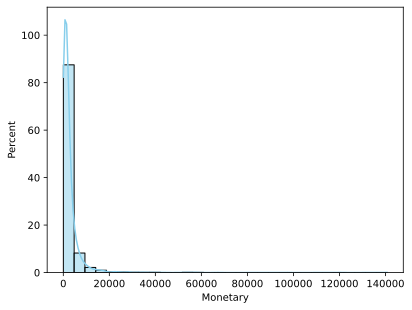

In [34]:
sns.histplot(finalDataset['Monetary'],bins=30, kde=True, color="skyblue", stat="percent")

In [35]:
print(finalDataset['Monetary'].describe())

count      3162.000000
mean       2625.359027
std        5700.844639
min          24.050000
25%         620.295000
50%        1227.180000
75%        2670.187500
max      140716.640000
Name: Monetary, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgInvoiceValue', ylabel='Percent'>

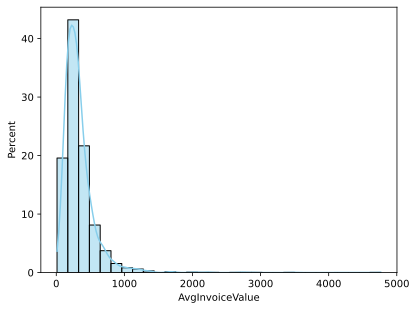

In [36]:
sns.histplot(finalDataset['AvgInvoiceValue'],bins=30, kde=True, color="skyblue", stat="percent")

In [37]:
print(finalDataset['AvgInvoiceValue'].describe())

count    3162.000000
mean      331.632871
std       247.136847
min        11.161333
25%       190.705227
50%       281.127981
75%       395.264167
max      4765.040000
Name: AvgInvoiceValue, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgQuantityPerInvoice', ylabel='Percent'>

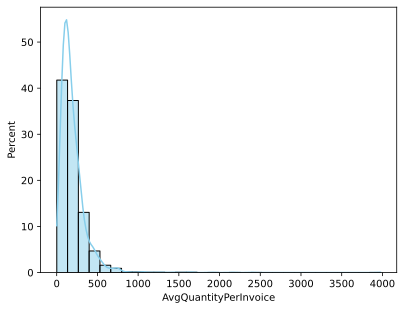

In [38]:
sns.histplot(finalDataset['AvgQuantityPerInvoice'],bins=30, kde=True, color="skyblue", stat="percent")

In [39]:
print(finalDataset['AvgQuantityPerInvoice'].describe())

count    3162.000000
mean      194.205143
std       173.997557
min         1.000000
25%        95.643939
50%       152.585714
75%       243.421875
max      3976.875000
Name: AvgQuantityPerInvoice, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FrequencyPerMonth', ylabel='Percent'>

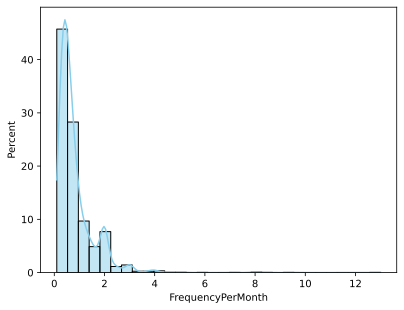

In [40]:
sns.histplot(finalDataset['FrequencyPerMonth'],bins=30, kde=True, color="skyblue", stat="percent")

In [41]:
print(finalDataset['FrequencyPerMonth'].describe())

count    3162.000000
mean        0.829626
std         0.775146
min         0.099477
25%         0.375802
50%         0.579810
75%         0.981935
max        12.997796
Name: FrequencyPerMonth, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Frequency', ylabel='Percent'>

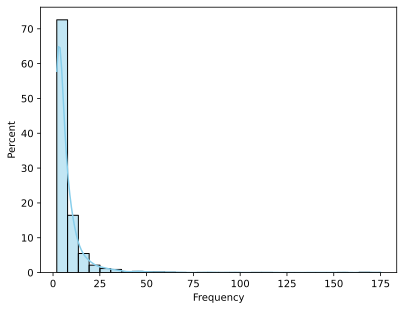

In [42]:
sns.histplot(finalDataset['Frequency'],bins=30, kde=True, color="skyblue", stat="percent")

In [43]:
print(finalDataset['Frequency'].describe())

count    3162.000000
mean        7.087919
std         9.926741
min         2.000000
25%         3.000000
50%         4.000000
75%         8.000000
max       175.000000
Name: Frequency, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FutureCLV', ylabel='Percent'>

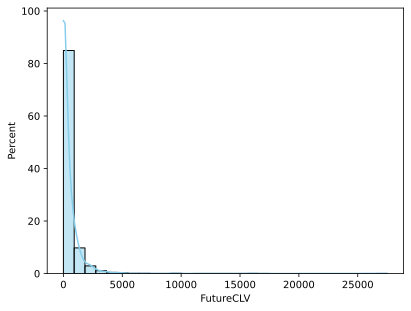

In [44]:
sns.histplot(finalDataset['FutureCLV'],bins=30, kde=True, color="skyblue", stat="percent")

In [45]:
print(finalDataset['FutureCLV'].describe())

count     3162.000000
mean       469.602040
std       1173.615276
min          0.000000
25%          0.000000
50%         88.270000
75%        556.775000
max      27507.590000
Name: FutureCLV, dtype: float64


In [46]:
#Dropping the outliers from data and saving them on other dataset!
# finalDatasetOutliersMonetary= finalDataset[finalDataset['Monetary'] > finalDataset['Monetary'].quantile(0.98)]

# finalDataset = finalDataset[finalDataset['Monetary'] < finalDataset['Monetary'].quantile(0.98)]
# finalDataset = finalDataset[finalDataset['AvgInvoiceValue'] < finalDataset['AvgInvoiceValue'].quantile(0.98)]
# finalDataset = finalDataset[finalDataset['AvgQuantityPerInvoice'] < finalDataset['AvgQuantityPerInvoice'].quantile(0.98)]
# finalDataset = finalDataset[finalDataset['Frequency'] < finalDataset['Frequency'].quantile(0.98)]
# finalDataset = finalDataset[finalDataset['FrequencyPerMonth'] < finalDataset['FrequencyPerMonth'].quantile(0.99)]
# finalDataset = finalDataset[finalDataset['FutureCLV'] < finalDataset['FutureCLV'].quantile(0.99)]
# finalDataset = finalDataset[finalDataset['FrequencyPerMonth'] < finalDataset['FrequencyPerMonth'].quantile(0.99)]
# finalDataset = finalDataset[finalDataset['ProductDiversity'] < finalDataset['ProductDiversity'].quantile(0.99)]

# Probando eliminando los clientes que no compran en ese trimestre!
#finalDataset = finalDataset[finalDataset['FutureCLV'] > 0]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Monetary', ylabel='Percent'>

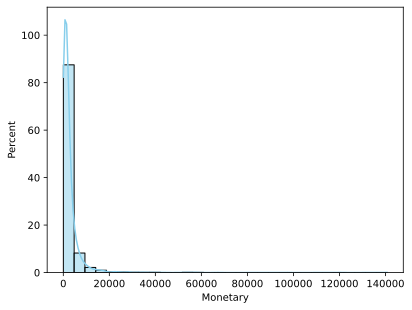

In [47]:
sns.histplot(finalDataset['Monetary'],bins=30, kde=True, color="skyblue", stat="percent")

In [48]:
print(finalDataset['Monetary'].describe())

count      3162.000000
mean       2625.359027
std        5700.844639
min          24.050000
25%         620.295000
50%        1227.180000
75%        2670.187500
max      140716.640000
Name: Monetary, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgInvoiceValue', ylabel='Percent'>

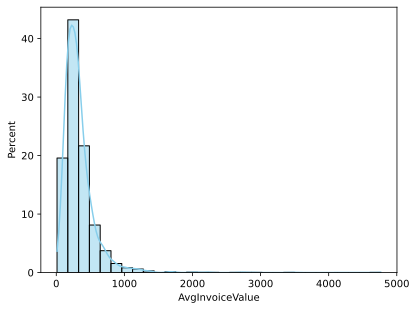

In [49]:
sns.histplot(finalDataset['AvgInvoiceValue'],bins=30, kde=True, color="skyblue", stat="percent")

In [50]:
print(finalDataset['AvgInvoiceValue'].describe())

count    3162.000000
mean      331.632871
std       247.136847
min        11.161333
25%       190.705227
50%       281.127981
75%       395.264167
max      4765.040000
Name: AvgInvoiceValue, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgQuantityPerInvoice', ylabel='Percent'>

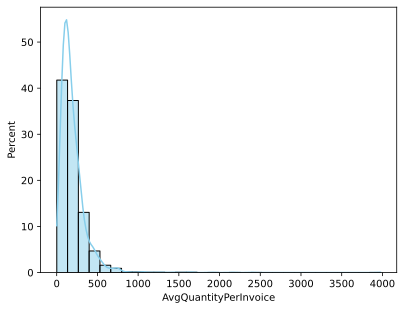

In [51]:
sns.histplot(finalDataset['AvgQuantityPerInvoice'],bins=30, kde=True, color="skyblue", stat="percent")

In [52]:
print(finalDataset['AvgQuantityPerInvoice'].describe())

count    3162.000000
mean      194.205143
std       173.997557
min         1.000000
25%        95.643939
50%       152.585714
75%       243.421875
max      3976.875000
Name: AvgQuantityPerInvoice, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FrequencyPerMonth', ylabel='Percent'>

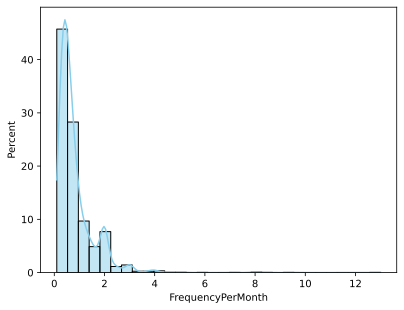

In [53]:
sns.histplot(finalDataset['FrequencyPerMonth'],bins=30, kde=True, color="skyblue", stat="percent")

In [54]:
print(finalDataset['FrequencyPerMonth'].describe())

count    3162.000000
mean        0.829626
std         0.775146
min         0.099477
25%         0.375802
50%         0.579810
75%         0.981935
max        12.997796
Name: FrequencyPerMonth, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Frequency', ylabel='Percent'>

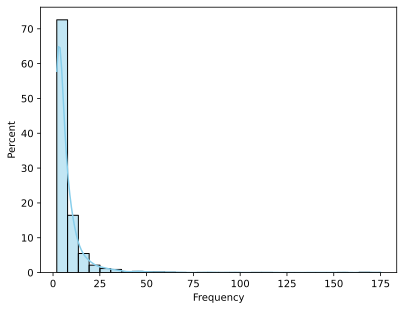

In [55]:
sns.histplot(finalDataset['Frequency'],bins=30, kde=True, color="skyblue", stat="percent")

In [56]:
print(finalDataset['Frequency'].describe())

count    3162.000000
mean        7.087919
std         9.926741
min         2.000000
25%         3.000000
50%         4.000000
75%         8.000000
max       175.000000
Name: Frequency, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FutureCLV', ylabel='Percent'>

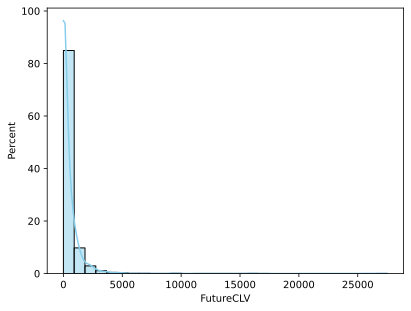

In [57]:
sns.histplot(finalDataset['FutureCLV'],bins=30, kde=True, color="skyblue", stat="percent")

In [58]:
print(finalDataset['FutureCLV'].describe())

count     3162.000000
mean       469.602040
std       1173.615276
min          0.000000
25%          0.000000
50%         88.270000
75%        556.775000
max      27507.590000
Name: FutureCLV, dtype: float64


# Normalizacion de la data

In [59]:
modelData = finalDataset.copy()

In [60]:
# Hacer log transform a la data numerica con heavy-tail
logCols = ['Monetary', 'AvgInvoiceValue', 'AvgQuantityPerInvoice', 'Frequency']

# Add temporal spending features (also heavy-tailed)
logCols += ['Spending_Last30d', 'Spending_Last60d', 'Spending_Last90d']

# Add temporal frequency features
logCols += ['Frequency_Last30d', 'Frequency_Last60d', 'Frequency_Last90d']

for col in logCols:
    modelData[col] = np.log1p(modelData[col])

In [61]:
# Robust scaling for features

featureCols = ['Monetary', 'AvgInvoiceValue', 'AvgQuantityPerInvoice', 'Frequency', 'Recency', 'ActiveDays', 'FrequencyPerMonth', 'ProductDiversity']

# Add temporal features
featureCols += ['Spending_Last30d', 'Spending_Last60d', 'Spending_Last90d']
featureCols += ['Frequency_Last30d', 'Frequency_Last60d', 'Frequency_Last90d']

scaler = RobustScaler()
modelData[featureCols] = scaler.fit_transform(modelData[featureCols])

In [62]:
modelData[featureCols].describe()

,Monetary,AvgInvoiceValue,AvgQuantityPerInvoice,Frequency,Recency,ActiveDays,FrequencyPerMonth,ProductDiversity,Spending_Last30d,Spending_Last60d,Spending_Last90d,Frequency_Last30d,Frequency_Last60d,Frequency_Last90d
count,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000
mean,0.056662,-0.027559,-0.018800,0.239217,0.214284,-0.006819,0.412148,0.354978,1.216100,0.377261,0.460674,0.168661,0.462472,0.650187
std,0.741933,0.833256,0.788081,0.820462,0.590396,0.564879,1.278838,1.189927,2.393776,0.528386,0.524212,0.345964,0.698170,0.822375
min,-2.668830,-4.329987,-4.678617,-0.629926,-0.445833,-0.943820,-0.792454,-0.709302,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.467258,-0.532144,-0.499239,-0.275170,-0.287500,-0.508614,-0.336571,-0.360465,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.532742,0.467856,0.500761,0.724830,0.712500,0.491386,0.663429,0.639535,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,3.250814,3.893161,3.507250,4.391310,2.212500,0.964794,20.487230,21.651163,9.038439,1.768982,1.691345,2.397895,4.523562,5.000000


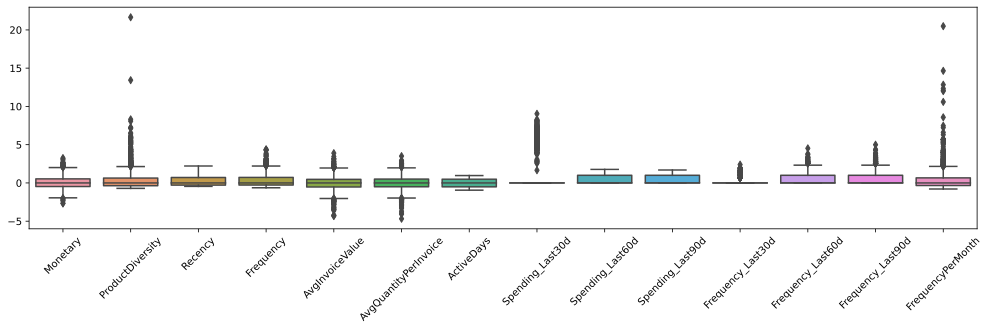

In [63]:
# check the new distribution
Showdata=modelData.drop(columns=['FutureCLV'])
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(Showdata)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

# Definition of train/test/val datasets

In [64]:
# Separating features from target
X = modelData.drop(columns=['FutureCLV'])
y = modelData['FutureCLV']

# Split en train, test y val (70%, 15%, 15%)

# Train and temp split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Val and test splot
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Pandas dataframe to tensor conversion
X_train_t = torch.tensor(X_train.values).float()
X_val_t   = torch.tensor(X_val.values).float()
X_test_t  = torch.tensor(X_test.values).float()

y_train_t = torch.tensor(y_train.values).float().unsqueeze(1)
y_val_t   = torch.tensor(y_val.values).float().unsqueeze(1)
y_test_t  = torch.tensor(y_test.values).float().unsqueeze(1)

In [65]:
# Dataloaders

batchSize = 32

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=batchSize, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batchSize, shuffle=True)

In [66]:
print(X_train_t.shape)
print(X_val_t.shape)
print(X_test_t.shape)

torch.Size([2213, 14])
torch.Size([474, 14])
torch.Size([475, 14])


# Creating and trainning the FFNN

In [67]:
# Creating a class for the model without batchnorm

class FFNN(nn.Module):
  def __init__(self):
    super().__init__()

    # input layer
    self.input = nn.Linear(14,32)

    # hidden layer 1
    self.fc1    = nn.Linear(32,16)

    # hidden layer 2
    self.fc2    = nn.Linear(16,8)

    # output layer
    self.output = nn.Linear(8,1)

    # Dropout
    self.dropout = nn.Dropout(p=0.15)

  # forward pass
  def forward(self,x):

    # input
    x = self.input(x)    # weighted combination
    x = F.relu(x)      # activation function 
      
    # hidden layer 1
    x = self.fc1(x)    # weighted combination
    x = F.relu(x)      # activation function
    x = self.dropout(x)  # dropout
    
    # hidden layer 2
    x = self.fc2(x)    # weighted combination
    x = F.relu(x)      # activation function 

    # output layer
    return self.output(x)

In [68]:
# grab an instance of the model class
model = FFNN()

# loss function
# we should use Huberloss() because its better for outliers
lossfun = nn.HuberLoss() # Could use nn.MSELoss() but HuberLoss() is better in this case

# optimizer with L2 Regularization 
optimizer = torch.optim.AdamW(model.parameters(),lr= 0.001,weight_decay=0.0001)

# Scheduler for learning rate decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,     # reduce LR by half
    patience=10,     # wait 15 epochs with no improvement
    min_lr = 0.000001,
    verbose = True # helps debugging
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [69]:
# train the model

# Evaluation function
def evaluateModel(model, loader):
    model.eval()

    preds = []
    trues = []

    with torch.no_grad():
            for X, y in loader:
                yhat = model(X)
                preds.append(yhat.cpu().numpy())
                trues.append(y.cpu().numpy())

    preds = np.vstack(preds).ravel()
    trues = np.vstack(trues).ravel()

    mae = mean_absolute_error(trues, preds) 
    rmse = np.sqrt(mean_squared_error(trues, preds))
    r2 = r2_score(trues, preds)

    return mae, rmse, r2

# Epochs
numepochs = 100

def trainTheModel():

    # initialize losses as empties
    trainLosses = []
    valLosses = []
    
    valMAEs = []
    valRMSEs = []
    valR2s = []
    
    # loop over epochs
    for epoch in range(numepochs):
    
        # Toggle train mode
        model.train()
        batchLoss = []
          
        # initialize batchAcc and batchLoss
        batchAcc  = []
        batchLoss = []
        
        for X,y in train_loader:
          # Clear old gradients  
          optimizer.zero_grad()  
        
          # forward pass and loss
          yhat = model(X)
          loss = lossfun(yhat,y)
        
          # backprop
          loss.backward()
          optimizer.step()
        
          # Append batch Loss
          batchLoss.append( loss.item())
          
        # Average trainning loss for this epoch
        trainLoss = np.mean(batchLoss)
        trainLosses.append(trainLoss)

        # Turning on validation mode
        model.eval()
        with torch.no_grad():
            valLossBatch = []

            for Xv, yv in val_loader:
                yhatv = model(Xv)
                valLossBatch.append(lossfun(yhatv, yv).item())

        valLoss = np.mean(valLossBatch)
        valLosses.append(valLoss)

        # Metrics
        mae, rmse, r2 = evaluateModel(model, val_loader)

        valMAEs.append(mae)
        valRMSEs.append(rmse)
        valR2s.append(r2)
            
        # Scheduler
        scheduler.step(valLoss)

        # Progress print
        print(
            f"Epoch {epoch:03d} | "
            f"TrainLoss: {trainLoss:.4f} | "
            f"ValLoss: {valLoss:.4f} | "
            f"MAE: {mae:.2f} | "
            f"RMSE: {rmse:.2f} | "
            f"R²: {r2:.3f}"
        )
    
    # function output
    return trainLosses, valLosses, valMAEs, valRMSEs, valR2s

In [70]:
# Train the model
trainLosses, valLosses, valMAEs, valRMSEs, valR2s = trainTheModel()

Epoch 000 | TrainLoss: 490.1557 | ValLoss: 441.9951 | MAE: 444.27 | RMSE: 1257.51 | R²: -0.141
Epoch 001 | TrainLoss: 484.5229 | ValLoss: 436.3053 | MAE: 439.77 | RMSE: 1248.08 | R²: -0.124
Epoch 002 | TrainLoss: 469.1622 | ValLoss: 412.2373 | MAE: 411.06 | RMSE: 1189.46 | R²: -0.021
Epoch 003 | TrainLoss: 425.4395 | ValLoss: 384.7709 | MAE: 379.52 | RMSE: 1103.73 | R²: 0.121
Epoch 004 | TrainLoss: 403.0876 | ValLoss: 373.2686 | MAE: 375.50 | RMSE: 1082.55 | R²: 0.154
Epoch 005 | TrainLoss: 403.3497 | ValLoss: 370.3382 | MAE: 372.65 | RMSE: 1074.17 | R²: 0.167
Epoch 006 | TrainLoss: 395.6669 | ValLoss: 372.7763 | MAE: 369.82 | RMSE: 1067.56 | R²: 0.178
Epoch 007 | TrainLoss: 391.2038 | ValLoss: 366.6582 | MAE: 368.14 | RMSE: 1059.35 | R²: 0.190
Epoch 008 | TrainLoss: 389.3325 | ValLoss: 366.6336 | MAE: 366.85 | RMSE: 1050.68 | R²: 0.203
Epoch 009 | TrainLoss: 390.8442 | ValLoss: 362.9801 | MAE: 363.44 | RMSE: 1049.27 | R²: 0.206
Epoch 010 | TrainLoss: 381.9288 | ValLoss: 373.0825 | MAE

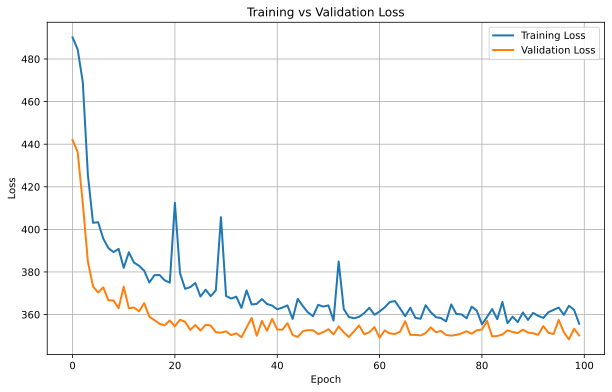

In [71]:
plt.figure(figsize=(10,6))

plt.plot(trainLosses, label='Training Loss', linewidth=2)
plt.plot(valLosses, label='Validation Loss', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()